Imports

In [25]:
%load_ext autoreload
%autoreload 2
from translation import BasicBenchmarkTranslator, FJSSPInstancesTranslator, SimpleGAEncoder, GurobiEncoder
from model import Order, ProductionEnvironment, reset_entities, soft_reset
from solver import GASolver, GreedyAgentSolver, PSOSolver, StagedGA, GurobiSolver
from evaluation import Evaluator, Makespan, IdleTime, TimeDeviation, Profit, UnfulfilledOrders, Tardiness
from visualization import visualize_schedule
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h3>Setup</h3>

In [2]:
order_amount = 10

Data Selection (Only run one of the following blocks)

In [26]:
reset_entities()
fjssp_translator = FJSSPInstancesTranslator()
production_environment = fjssp_translator.translate('6_Fattahi', 10)

In [2]:
reset_entities()
simple_translator = BasicBenchmarkTranslator()
production_environment = simple_translator.translate(3)

Order Generation

In [27]:
def generate_random_orders(amount : int, production_enviornment : ProductionEnvironment) -> list[Order]:
    available_resources = production_enviornment.resources # NOTE: currently works because all resources can be produced
    orders : list[Order] = []
    for i in range(amount):
        resource_id = random.randint(0, len(available_resources)-1)
        resource = production_environment.get_resource(resource_id)
        order = Order(arrival_time=0, delivery_time=1000, latest_acceptable_time=1000, resources=[(resource, 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0) # NOTE: randomize later
        orders.append(order)
    return orders

def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

random.seed(1) # for comparisons

#orders = generate_random_orders(order_amount, production_environment) # NOTE: some of the data is currently the same for every order
orders = generate_one_order_per_recipe(production_environment)

Solver Selection and Configuration (Only run one of the following blocks)

In [175]:
soft_reset()
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders) # NOTE: create duration dictionary
solver = GASolver(values, durations, jobs, production_environment, orders)

start_time_slot = 0
end_time_slot = 1000
population_size = 50
offspring_amount = 2 * population_size
max_generations = 10000
keep_parents = 0#int(population_size/4)#int(population_size / 6) #NOTE: weirdly only applies if keep_elitism=0, otherwise keep_elitism is used
keep_elitism= int(population_size/4)
crossover = 'two_points' # available options: single_point, two_points, uniform, scattered
selection = 'tournament' # available options: sss (Stead State Selection), rws (Roulette Wheel Selection), sus (Stochastic Universal Selection), rank (Rank Selection), random (Random Selection), tournament (Torunament Selection)
k_tournament = int(population_size/4)
mutation = 'force_feasible' # available options: workstation_only, full_random, random_only_feasible, force_feasible

solver.initialize(earliest_slot=start_time_slot, last_slot=end_time_slot, population_size=population_size, offspring_amount=offspring_amount, max_generations=max_generations, crossover=crossover, selection=selection, mutation=mutation, k_tournament=k_tournament, keep_parents=keep_parents, keep_elitism=keep_elitism)

In [278]:
soft_reset()
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders) # NOTE: create duration dictionary
solver = GreedyAgentSolver(values, durations, jobs, production_environment, orders)

In [208]:
soft_reset()
start_time_slot = 0
end_time_slot = 1000
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders)
solver = PSOSolver(production_environment=production_environment, encoder=encoder, jobs=jobs, durations=durations, start_time=start_time_slot, end_time=end_time_slot, orders=orders)
use_alternative = True
if not use_alternative:
    solver.initialize(dimensions=len(values), max_iterations=10000, update_weights=False, lower_bounds=[start_time_slot] * len(values), upper_bounds=[end_time_slot] * len(values))
else:
    # TODO: change feasibility and fitness functions NOTE: needs alternative encoder
    lower_bounds = []
    upper_bounds = []
    for i in range(len(values)):
        if i % 2 == 0:
            # bounds for workstation
            lower_bounds.append(0)
            upper_bounds.append(len(production_environment.get_available_workstations_for_task(jobs[int(i/2)])))
        else:
            # bounds for start times
            lower_bounds.append(start_time_slot)
            upper_bounds.append(end_time_slot)
    solver.initialize(dimensions=len(values), max_iterations=10000, update_weights=False, lower_bounds=lower_bounds, upper_bounds=upper_bounds, use_alternative=True)

In [162]:
soft_reset()
encoder = SimpleGAEncoder()
values, durations, jobs = encoder.encode(production_environment, orders)
solver = StagedGA(production_environment=production_environment)

solver.initialize(values, jobs, durations, 0, 1000)


In [33]:
soft_reset()
encoder = GurobiEncoder()
nb_machines, nb_jobs, nb_operations, job_ops_machs, durations, job_op_suitable, upper_bound, jobs = encoder.encode(production_environment, orders)
solver = GurobiSolver(production_environment)
solver.initialize(nb_jobs, nb_operations, nb_machines, job_ops_machs, durations, job_op_suitable, upper_bound)

Objective Selection (Multiple objectives can be added) NOTE: currently only the first added objective is considered during optimization

In [29]:
solver.add_objective(Makespan())

In [177]:
solver.add_objective(IdleTime())

In [178]:
solver.add_objective(TimeDeviation())

In [179]:
solver.add_objective(Tardiness())

In [180]:
solver.add_objective(Profit())

In [181]:
solver.add_objective(UnfulfilledOrders())

<h3>Run the Solver</h3>

In [34]:
# TODO: solver.reset()
solver.run()

Minimize
  Cmax
Subject To
  Y_const[1,1]: Y[1,1,1] = 1
  Y_const[1,2]: Y[1,2,2] + Y[1,2,4] = 1
  Y_const[1,3]: Y[1,3,4] + Y[1,3,5] = 1
  Y_const[2,1]: Y[2,1,1] + Y[2,1,3] = 1
  Y_const[2,2]: Y[2,2,2] + Y[2,2,3] = 1
  Y_const[2,3]: Y[2,3,5] = 1
  Y_const[3,1]: Y[3,1,1] + Y[3,1,2] = 1
  Y_const[3,2]: Y[3,2,3] = 1
  Y_const[3,3]: Y[3,3,4] + Y[3,3,5] = 1
  Y_const[4,1]: Y[4,1,1] + Y[4,1,2] = 1
  Y_const[4,2]: Y[4,2,5] = 1
  Y_const[4,3]: Y[4,3,3] + Y[4,3,4] = 1
  C_time[1,1]: 147.0 Y[1,1,1] + -1.0 C[1,1] <= 0
  C_time[2,1]: 214.0 Y[2,1,1] + 150.0 Y[2,1,3] + -1.0 C[2,1] <= 0
  C_time[3,1]: 87.0 Y[3,1,1] + 62.0 Y[3,1,2] + -1.0 C[3,1] <= 0
  C_time[4,1]: 87.0 Y[4,1,1] + 65.0 Y[4,1,2] + -1.0 C[4,1] <= 0
  C_time[1,2]: 130.0 Y[1,2,2] + 140.0 Y[1,2,4] + C[1,1] + -1.0 C[1,2] <= 0
  C_time[1,3]: 150.0 Y[1,3,4] + 160.0 Y[1,3,5] + C[1,2] + -1.0 C[1,3] <= 0
  C_time[2,2]: 66.0 Y[2,2,2] + 87.0 Y[2,2,3] + C[2,1] + -1.0 C[2,2] <= 0
  C_time[2,3]: 178.0 Y[2,3,5] + C[2,2] + -1.0 C[2,3] <= 0
  C_time[3,2]

In [31]:
print(solver.get_best())
print(solver.get_best_fitness())

({(1, 1, 2, 1): -0.0, (1, 1, 2, 2): 0.0, (1, 1, 2, 3): 0.0, (1, 1, 3, 1): 1.0, (1, 1, 3, 2): 0.0, (1, 1, 3, 3): 0.0, (1, 1, 4, 1): -0.0, (1, 1, 4, 2): 0.0, (1, 1, 4, 3): 0.0, (1, 2, 2, 1): 0.0, (1, 2, 2, 2): 1.0, (1, 2, 2, 3): 0.0, (1, 2, 3, 1): 1.0, (1, 2, 3, 2): 0.0, (1, 2, 3, 3): -0.0, (1, 2, 4, 1): 1.0, (1, 2, 4, 2): 0.0, (1, 2, 4, 3): -0.0, (1, 3, 2, 1): 0.0, (1, 3, 2, 2): 0.0, (1, 3, 2, 3): -0.0, (1, 3, 3, 1): 0.0, (1, 3, 3, 2): 0.0, (1, 3, 3, 3): -0.0, (1, 3, 4, 1): 0.0, (1, 3, 4, 2): -0.0, (1, 3, 4, 3): 1.0, (2, 1, 3, 1): -0.0, (2, 1, 3, 2): 0.0, (2, 1, 3, 3): 0.0, (2, 1, 4, 1): -0.0, (2, 1, 4, 2): 0.0, (2, 1, 4, 3): -0.0, (2, 2, 3, 1): -0.0, (2, 2, 3, 2): -0.0, (2, 2, 3, 3): 0.0, (2, 2, 4, 1): 1.0, (2, 2, 4, 2): 0.0, (2, 2, 4, 3): -0.0, (2, 3, 3, 1): 0.0, (2, 3, 3, 2): 0.0, (2, 3, 3, 3): 0.0, (2, 3, 4, 1): 0.0, (2, 3, 4, 2): 1.0, (2, 3, 4, 3): 0.0, (3, 1, 4, 1): -0.0, (3, 1, 4, 2): 0.0, (3, 1, 4, 3): 0.0, (3, 2, 4, 1): 0.0, (3, 2, 4, 2): 0.0, (3, 2, 4, 3): -0.0, (3, 3, 4, 1): 

In [183]:
print(solver.memory_duplicate)

19459


<h3>Evaluation</h3>

If the used Solver provides improvement history:

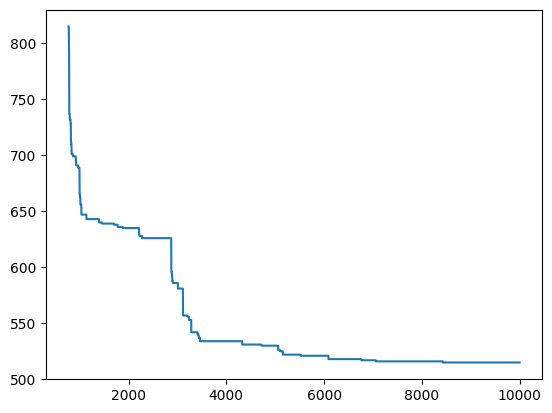

In [184]:
import matplotlib.pyplot as plt
best_history = solver.best_history
generation_average_history = solver.average_history

plt.plot(best_history)
plt.plot(generation_average_history)
plt.show()

In [ ]:
schedule = encoder.decode(solver.get_best(), jobs, production_environment, solver=solver)

TODO: change decoder signature, use different cell for gurobi for now

In [45]:
xsol, ysol, csol = solver.get_best() # TODO: change signature
schedule = encoder.decode(xsol, ysol, csol, job_ops_machs, durations, production_environment, jobs, solver)

Visualization

In [46]:
visualize_schedule(schedule, production_environment, orders)

Objective Values

In [ ]:
evaluator = Evaluator(production_environment)
evaluator.add_objective(Makespan())
evaluator.add_objective(IdleTime())
evaluator.add_objective(TimeDeviation())
evaluator.add_objective(Tardiness())
evaluator.add_objective(Profit())
evaluator.add_objective(UnfulfilledOrders())
objective_values = evaluator.evaluate(schedule, jobs)
print(f'Solution created with: {solver.name}')
print(objective_values)

In [1]:
#just testing with python
values = [0, 1, 0, 1, 0, 1, 0, 1]
zeros = values[::2]
ones = values[1::2]
print(zeros)
print(ones)

[0, 0, 0, 0]
[1, 1, 1, 1]
